In [1]:
from groq import Groq
import os
import pandas as pd
import numpy as np
import time
import csv

In [ ]:
notes_df = pd.read_csv('note classification\\Notes.csv')
train_df = pd.read_csv('note classification\\train.csv')
test_df = pd.read_csv('note classification\\test.csv', encoding='cp1252')

test_df = test_df.dropna(subset=['label'])

In [ ]:

# To clean note data
client = Groq(
    api_key='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'
)

cleaned_df = notes_df.copy()


with open('note classification\\Notes.csv', 'r') as file:
    my_reader = csv.reader(file, delimiter=',')
    curr_idx = 0
    for row in my_reader:
        print("At row: ", curr_idx)
        if curr_idx == 0:
            curr_idx += 1
            continue
        
        for i in range(4):
            print("Processing segment: ", i+1)
            segment_note = row[3+i]
            
            prompt = "You are given a set of shorthand lecture notes written in fragmented style. Your task is to convert these notes into a single coherent paragraph using full, grammatically correct sentences.\n\n"
            prompt += "Instructions:\n"
            prompt += "1. Do not add any information not found in the notes.\n"
            prompt += "2. Do not include explanations, labels, or commentary—return only the final paragraph.\n"
            prompt += "3. Preserve all factual details and express them in smooth, natural English.\n"
            prompt += "4. The output must be a self-contained paragraph suitable for use in a textbook or structured dataset.\n\n"

            prompt += "Input:\n\n"
            prompt += segment_note + "\n\n"
            prompt += "Output:\n"
            prompt += "Only return the converted paragraph."
            
            error_count = 0
            while True:
                try:
                    chat_completion = client.chat.completions.create(
                    messages=[
                            {
                                "role": "user",
                                "content": prompt,
                            }
                        ],
                        model="meta-llama/llama-4-maverick-17b-128e-instruct",
                        stream=False,
                    )
                    
                    response = chat_completion.choices[0].message.content   
                except Exception as e:
                    print(f"Error occurred: {e}")
                    error_count += 1
                    if error_count > 50:
                        print("Error count exceeded, breaking out of loop.")
                        break
                    time.sleep(2)  
                    continue
                else:
                    if not response:
                        print("Empty response, retrying...")
                        error_count += 1
                        if error_count > 50:
                            print("Error count exceeded, breaking out of loop.")
                            break
                        time.sleep(2)  
                        continue
                    else:
                        break
            
            if error_count > 50:
                break
            
            refined_note = response
            
            cleaned_df.at[curr_idx-1, f'Segment{i+1}_Notes'] = refined_note
        curr_idx += 1
    


At row:  85
Processing segment:  1
Processing segment:  2
Processing segment:  3
Processing segment:  4
At row:  86
Processing segment:  1
Processing segment:  2
Processing segment:  3
Processing segment:  4
At row:  87
Processing segment:  1
Processing segment:  2
Processing segment:  3
Processing segment:  4
At row:  88
Processing segment:  1
Processing segment:  2
Processing segment:  3
Processing segment:  4
At row:  89
Processing segment:  1
Processing segment:  2
Processing segment:  3
Processing segment:  4
At row:  90
Processing segment:  1
Processing segment:  2
Processing segment:  3
Processing segment:  4
At row:  91
Processing segment:  1
Processing segment:  2
Processing segment:  3
Processing segment:  4
At row:  92
Processing segment:  1
Processing segment:  2
Processing segment:  3
Processing segment:  4
At row:  93
Processing segment:  1
Processing segment:  2
Processing segment:  3
Processing segment:  4
At row:  94
Processing segment:  1
Processing segment:  2
Proces

In [ ]:
cleaned_df.to_csv('note classification\\Cleaned_Notes.csv', index=False)

In [3]:
notes_df = pd.read_csv('note classification\\Cleaned_Notes.csv')

In [4]:
test_df.columns

Index(['Experiment', 'Topic', 'ID', 'Segment', 'IdeaUnit', 'label'], dtype='object')

In [6]:
client = Groq(
    api_key='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'
)

predictions_df = pd.DataFrame(columns=['Index', 'Topic', 'ID', 'Segment', 'Prediction', 'Response'])
    
mycount = 0
for segment_num in range(1,5):    
    for test_id in test_df['ID'].unique():
        mycount += 1
        test_rows = test_df[(test_df['ID'] == test_id) & (test_df['Segment'] == segment_num)]
        
        test_idx = test_rows.index[0]     
        print("Processing test row index:", test_idx)
        test_topic = test_rows['Topic'].values[0]
    
        mystr = ""
        idx = 1
        myid = None
        for _, row in train_df.iterrows():
            if row['Topic'] == test_topic and row['Segment'] == segment_num:
                mystr += f"Example {idx}:\n"
                mystr += f"Notes : {row['IdeaUnit']}\n"
                mystr += f"Covers the IdeaUnit? : {True if row['label'] else False}\n\n"
                myid = row['ID']
                idx+=1

        # print(mystr)  
        prompt = "You are an expert in evaluating student notes to determine whether they are relevant to and supported by a key lecture concept, called an IdeaUnit.\n\n"
        prompt += "- The IdeaUnit may contain some irrelevant, off-topic, or non-theoretical content (e.g., jokes, asides, unrelated remarks).\n"
        prompt += "- When making your judgment, ignore any content in the IdeaUnit that is clearly not theoretical or conceptual.\n"
        prompt += "- A student note is considered relevant if all of its ideas are consistent with, and can be directly traced back to, the theoretical or instructional parts of the IdeaUnit.\n"
        prompt += "- The note does not need to cover the entire IdeaUnit, but it must not introduce any ideas that are unsupported by or contradictory to the relevant content in the IdeaUnit.\n\n"
        prompt += "To better understand the task, consider the following ideaunit and examples:\n\n"
        
        train_row = notes_df[(notes_df['ID'] == myid)]
        train_ideaunit = train_row[f'Segment{segment_num}_Notes'].values[0]

        prompt += f"IdeaUnit: {train_ideaunit}\n\n"
        prompt += "Below are notes from different students. For each note, check if it covers the IdeaUnit.\n\n"
        prompt += mystr
        
        prompt += "Using your understanding from the above examples, determine if the series of notes which follow are relevant to the provided IdeaUnit. Make it certain to follow the instructions at the end of the prompt.\n\n" 
        
        check_row = notes_df[(notes_df['ID'] == test_id)]
        
        test_ideaunit = check_row[f'Segment{segment_num}_Notes'].values[0]
        
        prompt += f"IdeaUnit: {test_ideaunit}\n\n"
        
        idx = 1
        for _, row in test_rows.iterrows():
            prompt += f"Note {idx} : {row['IdeaUnit']}\n\n"
            idx+=1
        
        prompt += "For each note, check if it covers the IdeaUnit. Answer with 'True' or 'False'\n"
        prompt += "INSTRUCTIONS:\n- ONLY output a Python-style array of Booleans (e.g., [True, False, ...]).\n- Each Boolean in the array must match the note at the corresponding index.\n- DO NOT explain your answer or add any extra text.\n\n"
        prompt += "Output:\n"
        prompt += "Array of Booleans"
        
        error_count = 0
        while True:
            try:
                chat_completion = client.chat.completions.create(
                messages=[
                        {
                            "role": "user",
                            "content": prompt,
                        }
                    ],
                    model="meta-llama/llama-4-maverick-17b-128e-instruct",
                    stream=False,
                )
                
                response = chat_completion.choices[0].message.content   
            except Exception as e:
                print(f"Error occurred: {e}")
                error_count += 1
                if error_count > 50:
                    print("Error count exceeded, breaking out of loop.")
                    break
                time.sleep(2)  
                continue
            else:
                if not response:
                    print("Empty response, retrying...")
                    error_count += 1
                    if error_count > 50:
                        print("Error count exceeded, breaking out of loop.")
                        break
                    time.sleep(2)  
                    continue
                else:
                    break
        
        if error_count > 50:
            break
        
        og_response = response
        response = response.split('[')[1].split(']')[0]
        response = response.split(',')
        response = [x.strip() for x in response]
        response = [x.lower() == 'true' for x in response]
        
        for i in range(len(response)):
            predictions_df = predictions_df._append({
                'Index': test_rows.index[i],
                'Topic': test_topic,
                'ID': test_id,
                'Segment': segment_num,
                'Prediction': response[i],
                'Response': og_response
            }, ignore_index=True)
            
    
    predictions_df.to_csv('note classification\\left_predictions.csv', index=False)
    print(f"Predictions saved for Segment {segment_num}.")

Processing test row index: 0
Processing test row index: 57
Processing test row index: 114
Processing test row index: 171
Processing test row index: 228
Processing test row index: 285
Processing test row index: 342
Processing test row index: 399
Processing test row index: 456
Processing test row index: 513
Processing test row index: 570
Processing test row index: 627
Processing test row index: 684
Processing test row index: 741
Processing test row index: 798
Processing test row index: 855
Processing test row index: 912
Processing test row index: 969
Processing test row index: 1026
Processing test row index: 1083
Processing test row index: 1140
Processing test row index: 1197
Processing test row index: 1254
Processing test row index: 1311
Processing test row index: 1368
Processing test row index: 1425
Processing test row index: 1482
Processing test row index: 1539
Processing test row index: 1596
Processing test row index: 1653
Processing test row index: 1710
Processing test row index: 17

In [ ]:
predictions_df.head()

,Index,Topic,ID,Segment,Prediction,Response
0,0,ComputerScience,6260230,1,True,"```python\n[True, True, True, False, True, Tru..."
1,1,ComputerScience,6260230,1,True,"```python\n[True, True, True, False, True, Tru..."
2,2,ComputerScience,6260230,1,True,"```python\n[True, True, True, False, True, Tru..."
3,3,ComputerScience,6260230,1,False,"```python\n[True, True, True, False, True, Tru..."
4,4,ComputerScience,6260230,1,True,"```python\n[True, True, True, False, True, Tru..."


In [10]:
test_df = pd.read_csv('note classification\\test.csv', encoding='cp1252')

Accuracy: 0.7672266371592396
F1 Score: 0.6764541387024608
Precision: 0.6793035664139286
Recall: 0.6736285157337789


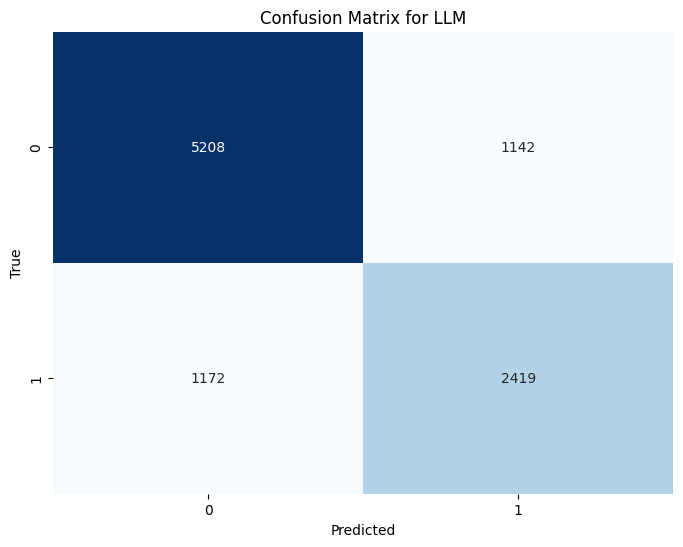

In [16]:
ground_truth = []
preds = []

for i in range(len(predictions_df)):
    ground_truth.append(test_df.iloc[predictions_df['Index'][i], -1])
    preds.append(1 if predictions_df['Prediction'][i] else 0)
    
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(ground_truth, preds)
f1 = f1_score(ground_truth, preds)
precision = precision_score(ground_truth, preds)
recall = recall_score(ground_truth, preds)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ground_truth, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for LLM")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
